Solution of the exercises
=========================

Solution of exercise 1
----------------------

Here's the solution for the IPT Solver written as a class:

In [22]:
from pytriqs.gf.local import *

class IPTSolver:
    def __init__(self, beta):
        self.beta = beta

        # Matsubara frequency Green's functions
        self.G_iw = BlockGf(name_list=["up"], block_list=[GfImFreq(indices=[0], beta=beta, name='G')])
        self.G0_iw = self.G_iw.copy() # will be set by the user after initialization
        self.Sigma_iw = self.G_iw.copy()
        
        # Imaginary time
        self.g0_tau = GfImTime(indices=[0], beta = self.beta, name='G0t')
        self.sigma_tau = self.g0_tau.copy()
        
    def solve(self, h_int): 
        #extract U from interaction hamiltonian
        for term, coeff in h_int:
           if len(term)==4: U = coeff
            
        self.g0_tau << InverseFourier(self.G0_iw["up"])
        self.sigma_tau << (U**2) * self.g0_tau * self.g0_tau * self.g0_tau
        self.Sigma_iw["up"] << Fourier(self.sigma_tau)
        
        # Dyson
        self.G_iw << inverse(inverse(self.G0_iw) - self.Sigma_iw)
        # or:
        # self.g << self.g0 * inverse(1.0 - self.sigma * self.g0)

Solution of exercise 2
----------------------

This is the implementation of the DMFT loop, with a plot of the interacting spectral function at every iteration.

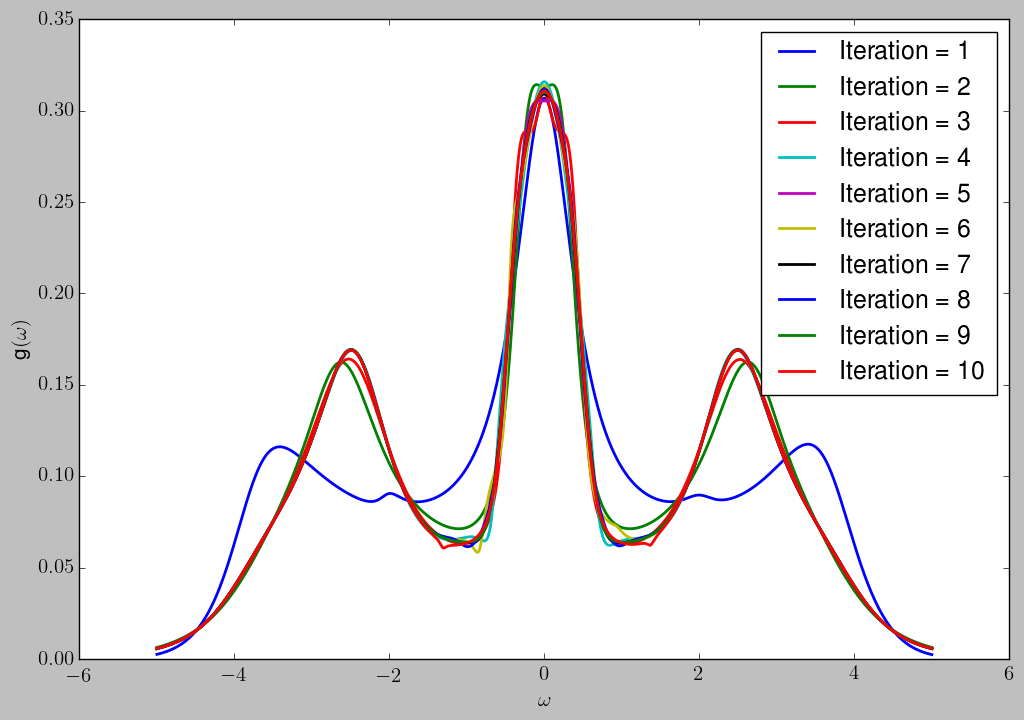

In [23]:
from pytriqs.plot.mpl_interface import *
from pytriqs.operators import n
%matplotlib inline
# change scale of all figures to make them bigger
import matplotlib as mpl
mpl.rcParams['savefig.dpi']=100 

t = 1.0
U = 4.0
beta = 20
n_loops = 10

S = IPTSolver(beta = beta)
S.G_iw["up"] << SemiCircular(2*t)

fig = plt.figure(figsize=(12,8))

for i in range(n_loops):
    S.G0_iw["up"] << inverse( iOmega_n - t**2 * S.G_iw["up"] )
    S.solve(h_int = U*n("up",0)*n("down",0))
    
    # Get real axis function with Pade approximation
    greal = GfReFreq(indices = [1], window = (-5.0,5.0))
    greal.set_from_pade(S.G_iw["up"], 100, 0.01)
    
    oplot(greal, mode='S', figure = fig, label = "Iteration = %i" % (i+1))

Solution of exercise 3
----------------------

From the solution above it seems that 10 iterations are enough to converge the
DMFT loop. Now it is easy to repeat this for several values of $U$.

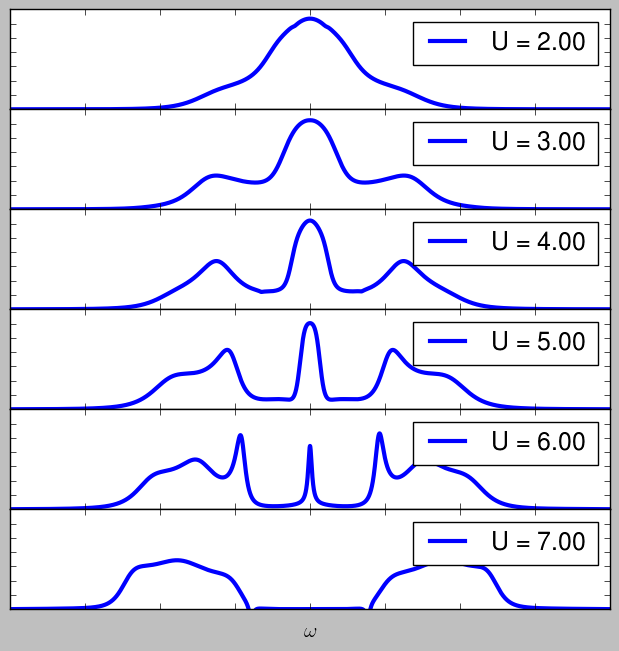

In [24]:
import numpy as np

t = 1.0
beta = 20
n_loops = 10

fig = plt.figure(figsize=(6,6))
pn = 0 # iteration counter for plotting

for U in np.arange(2.0, 7.5, 1.0):
    
    S = IPTSolver(beta = beta)
    S.G_iw["up"] << SemiCircular(2*t)

    # DMFT
    for i in range(n_loops):
        S.G0_iw["up"] << inverse( iOmega_n - t**2 * S.G_iw["up"] )
        S.solve(h_int = U*n("up",0)*n("down",0))

    # Get the real-axis with Pade approximation
    greal = GfReFreq(indices = [0], window = (-8.0,8.0))
    greal.set_from_pade(S.G_iw["up"], 100, 0.01)
    
    # plotting
    ax = fig.add_axes([0,1.-(pn+1)/6.,1,1./6.]) # subplot
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    oplot(greal, linewidth=3, mode='S', label = "U = %.2f" % U)
    plt.xlim(-8,8)
    plt.ylim(0,0.35)
    plt.ylabel("")
    pn = pn + 1

Comparison with the literature
-------------------------------

You can compare the result above with what can be found in the literature
(review of Antoine Georges et al.)

<img src="files/mott.png" width=30%>